The goal of our project was to familiarize ourselves with Open AI Gym and some Reinforcement Learning algorithms that we learned throughout the quarter. 

To begin, we wrote the Multi-Armed Bandit code (which was mainly learned in ML course) and the QLearning code to test out a simple Open AI Gym environment, Frozen Lake. The purpose of learning using both of these algorithms is to show the effectiveness of QLearning's ability to use possible future moves to sway its next action one way or another via the Q table. Multi-Armed Bandit does not use possible future state information to update its Q table. This is made evident by these lines of code that edit the Q tables in Multi-Armed Bandit and QLearning, respectively:
```
q_table[observation][choice] = q_table[observation][choice] + (1 / num_visits[observation][choice]) * (reward - q_table[observation][choice])
```
                        
                        
```
q_table[state][choice] = q_table[state][choice] + ((1 / num_visits[state][choice]) * (reward + (self.discount * np.max(q_table[state_prime, :])) - q_table[state][choice]))
```




In [9]:
import numpy as np
class MultiArmedBandit:

    def __init__(self, epsilon=0.2):
        self.epsilon = epsilon

    def fit(self, env, steps=1000):
        # create Q table that is the size of actions x states
        num_actions = env.action_space.n
        num_states = env.observation_space.n
        q_table = np.zeros((num_states, num_actions))
        num_visits = np.zeros((num_states, num_actions))
        observation = env.reset()
        rewards = []
        reward_total = 0
        s = np.floor(steps / 100)
        done = False

        for i in range(steps):
            if (i + 1) % s == 0:
                rewards.append(reward_total / s)
                reward_total = 0
            if done:
                env.reset()
            if np.random.random() > self.epsilon and len(np.unique(q_table[observation])) > 1:
                choice = np.argmax(q_table[observation])
            else:
                choice = env.action_space.sample()

            observation, reward, done, info = env.step(choice)
            num_visits[observation][choice] += 1
            reward_total += reward
            q_table[observation][choice] = q_table[observation][choice] + (1 / num_visits[observation][choice]) * (
                        reward - q_table[observation][choice])
        return q_table, rewards

    def predict(self, env, state_action_values):
        observation = env.reset()
        rewards = []
        actions = []
        states = []
        done = False

        while not done:
            choice = np.argmax(state_action_values[observation])
            observation, reward, done, info = env.step(choice)
            rewards.append(reward)
            actions.append(choice)
            states.append(observation)

        return np.array(states), np.array(actions), np.array(rewards)


class QLearning:
    def __init__(self, epsilon=0.2, discount=0.95, adaptive=False):
        self.epsilon = epsilon
        self.discount = discount
        self.adaptive = adaptive

    def fit(self, env, steps=1000):
        # create Q table that is the size of actions x states

        num_actions = env.action_space.n
        num_states = env.observation_space.n
        q_table = np.zeros((num_states, num_actions))
        num_visits = np.zeros((num_states, num_actions))
        state = env.reset()
        rewards = []
        reward_total = 0
        s = np.floor(steps / 100)
        done = False

        for i in range(steps):
            if done:
                state = env.reset()
            if (np.random.uniform() > self._get_epsilon(i / steps)) and (len(np.unique(q_table[state])) > 1):
                choice = np.argmax(q_table[state])
            else:
                choice = env.action_space.sample()
            #env.render()
            state_prime, reward, done, info = env.step(choice)
            num_visits[state][choice] += 1
            reward_total += reward
            q_table[state][choice] = q_table[state][choice] + ((1 / num_visits[state][choice]) * (
                        reward + (self.discount * np.max(q_table[state_prime, :])) - q_table[state][choice]))

            if (i + 1) % s == 0:
                rewards.append(reward_total / s)
                reward_total = 0
            state = state_prime

        return q_table, np.array(rewards)

    def predict(self, env, state_action_values):
             
        observation = env.reset()
        rewards = []
        actions = []
        states = []
        done = False

        while not done:
            choice = np.argmax(state_action_values[observation])
            observation, reward, done, info = env.step(choice)
            rewards.append(reward)
            actions.append(choice)
            states.append(observation)

        return np.array(states), np.array(actions), np.array(rewards)

    def _get_epsilon(self, progress):
        return self._adaptive_epsilon(progress) if self.adaptive else self.epsilon

    def _adaptive_epsilon(self, progress):
        return (1 - progress) * self.epsilon


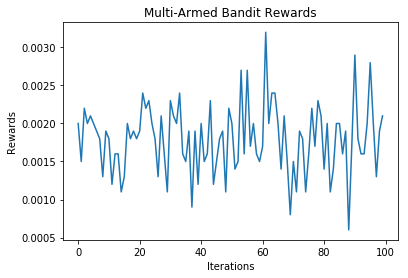

In [10]:
import gym
import numpy as np
try:
    import matplotlib.pyplot as plt
except:
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

agent = MultiArmedBandit()

q_tables = []
rewards_all = []
for i in range(10):
    state_action_values, rewards = agent.fit(env, steps=100000)
    q_tables.append(state_action_values)
    rewards_all.append(rewards)

plt.plot(np.average(rewards_all, axis=0))
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Multi-Armed Bandit Rewards')
plt.show()

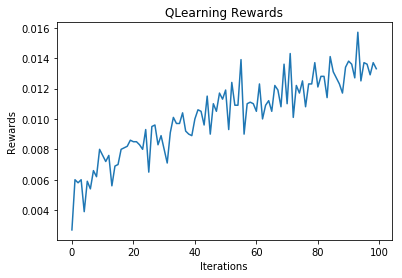

In [11]:
import gym
import numpy as np
try:
    import matplotlib.pyplot as plt
except:
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

agent = QLearning(adaptive=True)

q_tables = []
rewards_all = []
for i in range(10):
    state_action_values, rewards = agent.fit(env, steps=100000)
    q_tables.append(state_action_values)
    rewards_all.append(rewards)

plt.plot(np.average(rewards_all, axis=0))
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('QLearning Rewards')
plt.show()

As seen from the two graphs, QLearning is much more deliberate when finding the highest reward, as it steadily increases as iterations go on.